In [2]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile
from sklearn import metrics

In [3]:
#Importing data
data = pd.read_csv('../data/training_noemoticon.csv', header=None, encoding='latin-1')
data = data.to_numpy()

In [6]:
#Stemming and Removing Stop Words using nltk

#Function to preprocess the input x, for removing special characters and splitting the entire string
#Does stemming and removes stop words
#Also converts the entire text to lower case.

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
def process(x):
    l = []
    for i in x:
        t = (re.split("[^a-z0-9'@]", i.lower()))
        prime = []
        for j in t:
            j=ps.stem(j)
            if(j=='' or j in stop_words):
                continue
            if(j[0]=='@'):
                continue
            prime.append(j)
        l.append(prime)
    return l

In [3]:
#Segregating input data on the basis of their actual classes.

index_0 = np.argwhere(data[:,0]==0)[:,0]
index_1 = np.argwhere(data[:,0]==4)[:,0]

x_0 = data[index_0, 5]
y_0 = data[index_0, 0].reshape(-1,1)
count_0 = index_0.shape[0]

x_1 = data[index_1, 5]
y_1 = data[index_1, 0].reshape(-1,1)
count_1 = index_1.shape[0]

p_0 = np.log(count_0) - np.log(count_0 + count_1)
p_1 = np.log(count_1) - np.log(count_0 + count_1)

print(p_0, p_1)

print("Starting for class 0")
start = time.time()
x_0 = process(x_0)
elapsed = time.time()-start
print("Done for class 0, time elapsed is: ",elapsed, "\n")

print("Starting for class 1")
start = time.time()
x_1 = process(x_1)
elapsed = time.time()-start
print("Done for class 1, time elapsed is: ",elapsed, "\n")

-0.6931471805599454 -0.6931471805599454
Starting for class 0
Done for class 0, time elapsed is:  150.83837509155273 

Starting for class 1
Done for class 1, time elapsed is:  151.8660101890564 



In [14]:
# #Saving preprocessed text for future use
# f = open("x_0.txt", "w")
# for i in range(len(y_0)):
#     f.write(str(y_0[i][0]))
#     for j in x_0[i]:
#         f.write(" "+j)
#     f.write("\n")
    
# f = open("x_1.txt", "w")
# for i in range(len(y_1)):
#     f.write(str(y_1[i][0]))
#     for j in x_1[i]:
#         f.write(" "+j)
#     f.write("\n")

In [4]:
#Reading line fron x_0 and x_1, the preprocessed text stored
f = open("x_0.txt", "r")
y_0 = []
x_0 = []
for line in f:
    t = re.split(" ", line)
    y = int(t[0])
    t = t[1:]
    if(t!=[]):
        t[-1] = t[-1][:-1]
    y_0.append(y)
    x_0.append(t)
    
f = open("x_1.txt", "r")
y_1 = []
x_1 = []
for line in f:
    t = re.split(" ", line)
    y = int(t[0])
    t = t[1:]
    if(t!=[]):
        t[-1] = t[-1][:-1]
    y_1.append(y)
    x_1.append(t)

count_0 = len(y_0)
count_1 = len(y_1)

p_0 = np.log(count_0) - np.log(count_0 + count_1)
p_1 = np.log(count_1) - np.log(count_0 + count_1)

y_0 = np.array(y_0).reshape(-1,1)
y_1 = np.array(y_1).reshape(-1,1)

In [7]:
#Importing test data
test = pd.read_csv('../data/test.csv', header=None, encoding='latin-1')
test = test.to_numpy()

#Segregating test data on the bases of their class, and taking only class 0 and 4
index_t = np.union1d(np.argwhere(test[:,0]==0)[:,0], np.argwhere(test[:,0]==4)[:,0])
x_test = test[index_t, 5]
y_test = test[index_t, 0].reshape(-1,1)
x_test = process(x_test)

In [8]:
#Creating three diferent dictonaries, two for each classes and one for union of two
def add_dict(x_0, x_1):
    dict_t = {}
    dict_0 = {}
    dict_1 = {}
    for i in x_0:
        for j in i:
            if(j in dict_0):
                dict_0[j] = dict_0.get(j) + 1
            else:
                dict_0[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
                
    
    
    for i in x_1:
        for j in i:
            if(j in dict_1):
                dict_1[j] = dict_1.get(j) + 1
            else:
                dict_1[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
                
    return dict_t, dict_0, dict_1

dict_t, dict_0, dict_1 = add_dict(x_0, x_1)

In [9]:
#Total no of features, and their count in respective classes
no_of_words = len(dict_t)
total_words_0 = sum(dict_0.values())
total_words_1 = sum(dict_1.values())
c = 1

In [10]:
#Function to predict classes, and calculate accuracy of prediction.
#returns confusion matrix and scores of prediction as well
def accuracy(y, x):
    confusion = np.zeros([2,2])
    pred = []
    scores = []
    for i in range(len(x)):
        p0 = p_0
        p1 = p_1
        for j in x[i]:
            if(j in dict_0):
                p0 += np.log((dict_0[j]+1)) - np.log((total_words_0 + no_of_words*c))
            else:
                p0 += np.log(1) - np.log((total_words_0 + no_of_words*c))
                
            
            if(j in dict_1):
                p1 += np.log((dict_1[j]+1)) - np.log((total_words_1 + no_of_words*c))
            else:
                p1 += np.log(1) - np.log((total_words_1 + no_of_words*c))
        
        scores.append(np.exp(p1)/(np.exp(p0)+np.exp(p1)))
        if(p1>p0):
            pred.append(4)
        else:
            pred.append(0)
    
    total = len(pred)
    count_real = 0
    
    print(total)
    
    for i in range(len(pred)):
        if(pred[i]==int(y[i][0])):
            count_real += 1
            if(int(y[i][0])==0):
                confusion[0,0] += 1
            else:
                confusion[1,1] += 1
        else:
            if(int(y[i][0])==0):
                confusion[1,0] += 1
            else:
                confusion[0,1] += 1
                
    print(count_real)
    
    return count_real, total, confusion, scores

In [11]:
#Accuracy over the test set
count_real_test, total_test, confusion_test, scores_test = accuracy(y_test, x_test)
print("Accuracy of the model over test set is: ", count_real_test*100/total_test)

359
294
Accuracy of the model over test set is:  81.8941504178273


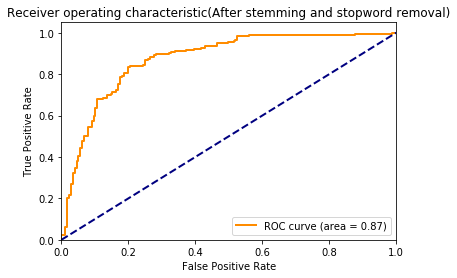

In [12]:
#Drawing ROC Curve on the basis of scores of prediction, after stopword removal and stemming

fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test.flatten(), dtype=np.int64), scores_test, pos_label=4)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(After stemming and stopword removal)')
plt.legend(loc="lower right")
plt.show()

In [15]:
#Creating three diferent dictonaries for bigrams, two for each classes and one for union of two
def add_dict_bigram(x_0, x_1):
    
    dict_t = {}
    dict_0 = {}
    dict_1 = {}
    
    for i in x_0:
        
        for j in i:
            if(j in dict_0):
                dict_0[j] = dict_0.get(j) + 1
            else:
                dict_0[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
        
        for item in nltk.bigrams(i):
            j = ' '.join(item)
            if(j in dict_0):
                dict_0[j] = dict_0.get(j) + 1
            else:
                dict_0[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
                
    
    
    for i in x_1:
        
        for j in i:
            if(j in dict_1):
                dict_1[j] = dict_1.get(j) + 1
            else:
                dict_1[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
        
        for item in nltk.bigrams(i):
            j = ' '.join(item)
            if(j in dict_1):
                dict_1[j] = dict_1.get(j) + 1
            else:
                dict_1[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
                
    return dict_t, dict_0, dict_1

dict_t, dict_0, dict_1 = add_dict_bigram(x_0, x_1)

In [16]:
#Total no of features, and their count in respective classes
no_of_words = len(dict_t)
total_words_0 = sum(dict_0.values())
total_words_1 = sum(dict_1.values())
c = 1

In [17]:
#Function to predict classes, and calculate accuracy of prediction.
#returns confusion matrix and scores of prediction as well
def accuracy_bigram(y, x):
    confusion = np.zeros([2,2])
    pred = []
    scores = []
    for i in range(len(x)):
        
        p0 = p_0
        p1 = p_1
        
        for j in x[i]:
            if(j in dict_0):
                p0 += np.log((dict_0[j]+1)) - np.log((total_words_0 + no_of_words*c))
            else:
                p0 += np.log(1) - np.log((total_words_0 + no_of_words*c))
                
            
            if(j in dict_1):
                p1 += np.log((dict_1[j]+1)) - np.log((total_words_1 + no_of_words*c))
            else:
                p1 += np.log(1) - np.log((total_words_1 + no_of_words*c))
        
        for item in nltk.bigrams(x[i]):
            j = ' '.join(item)
            if(j in dict_0):
                p0 += np.log((dict_0[j]+1)) - np.log((total_words_0 + no_of_words*c))
            else:
                p0 += np.log(1) - np.log((total_words_0 + no_of_words*c))
                
            
            if(j in dict_1):
                p1 += np.log((dict_1[j]+1)) - np.log((total_words_1 + no_of_words*c))
            else:
                p1 += np.log(1) - np.log((total_words_1 + no_of_words*c))
        
        scores.append(np.exp(p1)/(np.exp(p0)+np.exp(p1)))
        if(p1>p0):
            pred.append(4)
        else:
            pred.append(0)
    
    total = len(pred)
    count_real = 0
    
    print(total)
    
    for i in range(len(pred)):
        if(pred[i]==int(y[i][0])):
            count_real += 1
            if(int(y[i][0])==0):
                confusion[0,0] += 1
            else:
                confusion[1,1] += 1
        else:
            if(int(y[i][0])==0):
                confusion[1,0] += 1
            else:
                confusion[0,1] += 1
                
    print(count_real)
    
    return count_real, total, confusion, scores

In [28]:
#Accuracy over Class 0 of training set
accuracy_bigram(y_0, x_0)

800000
753234


(753234, 800000, array([[753234.,      0.],
        [ 46766.,      0.]]))

In [29]:
#Accuracy over class 4 of training set
accuracy_bigram(y_1, x_1)

800000
709520


(709520, 800000, array([[     0.,  90480.],
        [     0., 709520.]]))

In [18]:
#Accuracy and Confusion matrix of test set after taking bigrams
count_real_test, total_test, confusion_test, scores_test = accuracy_bigram(y_test, x_test)
print("Accuracy of the model over test set in bigram is: ", count_real_test*100/total_test)
print(confusion_test)

359
302
Accuracy of the model over test set in bigram is:  84.12256267409471
[[150.  30.]
 [ 27. 152.]]


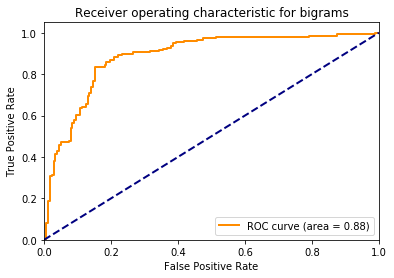

In [19]:
#Drawing ROC Curve on the basis of scores of prediction, for bigrams

fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test.flatten(), dtype=np.int64), scores_test, pos_label=4)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for bigrams')
plt.legend(loc="lower right")
plt.show()

In [20]:
#Creating three diferent dictonaries for trigrams, two for each classes and one for union of two
def add_dict_trigram(x_0, x_1):
    
    dict_t = {}
    dict_0 = {}
    dict_1 = {}
    
    for i in x_0:
        
        for j in i:
            if(j in dict_0):
                dict_0[j] = dict_0.get(j) + 1
            else:
                dict_0[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
        
        for item in nltk.trigrams(i):
            j = ' '.join(item)
            if(j in dict_0):
                dict_0[j] = dict_0.get(j) + 1
            else:
                dict_0[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
                
    
    
    for i in x_1:
        
        for j in i:
            if(j in dict_1):
                dict_1[j] = dict_1.get(j) + 1
            else:
                dict_1[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
        
        for item in nltk.trigrams(i):
            j = ' '.join(item)
            if(j in dict_1):
                dict_1[j] = dict_1.get(j) + 1
            else:
                dict_1[j] = 1
            
            if(j in dict_t):
                dict_t[j] = dict_t.get(j) + 1
            else:
                dict_t[j] = 1
                
    return dict_t, dict_0, dict_1

dict_t, dict_0, dict_1 = add_dict_trigram(x_0, x_1)

#Total no of features, and their count in respective classes
no_of_words = len(dict_t)
total_words_0 = sum(dict_0.values())
total_words_1 = sum(dict_1.values())
c = 1

In [23]:
#Function to predict classes, and calculate accuracy of prediction.
#returns confusion matrix and scores of prediction as well
def accuracy_trigram(y, x):
    confusion = np.zeros([2,2])
    pred = []
    scores = []
    for i in range(len(x)):
        
        p0 = p_0
        p1 = p_1
        
        for j in x[i]:
            if(j in dict_0):
                p0 += np.log((dict_0[j]+1)) - np.log((total_words_0 + no_of_words*c))
            else:
                p0 += np.log(1) - np.log((total_words_0 + no_of_words*c))
                
            
            if(j in dict_1):
                p1 += np.log((dict_1[j]+1)) - np.log((total_words_1 + no_of_words*c))
            else:
                p1 += np.log(1) - np.log((total_words_1 + no_of_words*c))
        
        for item in nltk.trigrams(x[i]):
            j = ' '.join(item)
            if(j in dict_0):
                p0 += np.log((dict_0[j]+1)) - np.log((total_words_0 + no_of_words*c))
            else:
                p0 += np.log(1) - np.log((total_words_0 + no_of_words*c))
                
            
            if(j in dict_1):
                p1 += np.log((dict_1[j]+1)) - np.log((total_words_1 + no_of_words*c))
            else:
                p1 += np.log(1) - np.log((total_words_1 + no_of_words*c))
        
        scores.append(np.exp(p1)/(np.exp(p0)+np.exp(p1)))  
        if(p1>p0):
            pred.append(4)
        else:
            pred.append(0)
    
    total = len(pred)
    count_real = 0
    
    print(total)
    
    for i in range(len(pred)):
        if(pred[i]==int(y[i][0])):
            count_real += 1
            if(int(y[i][0])==0):
                confusion[0,0] += 1
            else:
                confusion[1,1] += 1
        else:
            if(int(y[i][0])==0):
                confusion[1,0] += 1
            else:
                confusion[0,1] += 1
                
    print(count_real)
    
    return count_real, total, confusion, scores

In [24]:
#Accuracy and Confusion matrix of test set after taking trigrams
count_real_test, total_test, confusion_test, scores_test = accuracy_trigram(y_test, x_test)
print("Accuracy of the model over test set in trigram is: ", count_real_test*100/total_test)
print(confusion_test)

359
297
Accuracy of the model over test set in trigram is:  82.72980501392757
[[142.  27.]
 [ 35. 155.]]


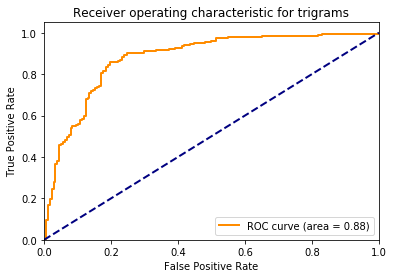

In [25]:
#Drawing ROC Curve on the basis of scores of prediction, for trigrams

fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test.flatten(), dtype=np.int64), scores_test, pos_label=4)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for trigrams')
plt.legend(loc="lower right")
plt.show()

In [19]:
#Accuracy over Class 0 of training set
accuracy_trigram(y_0, x_0)

800000
772356


(772356, 800000, array([[772356.,      0.],
        [ 27644.,      0.]]))

In [20]:
#Accuracy over Class 4 of training set
accuracy_trigram(y_1, x_1)

800000
755726


(755726, 800000, array([[     0.,  44274.],
        [     0., 755726.]]))

In [8]:
#Creating Strings for passing to Tfidf vectorizer of sklearn
#The words are already preprocesses
corpus = []

for i in x_0:
    corpus.append(' '.join(i))

for i in x_1:
    corpus.append(' '.join(i))
    
test_x = []
for i in x_test:
    test_x.append(" ".join(i))
    
x_0=[]
x_1=[]

In [9]:
#Calculating Termfrequency-InverseDocumentFrequency from sklearn library
vectorizer = TfidfVectorizer(stop_words='english')
train = vectorizer.fit_transform(corpus).astype(np.float32)
test = vectorizer.transform(test_x).astype(np.float32)
y_train = np.concatenate([y_0.flatten(), y_1.flatten()])

In [19]:
#Batch wise training of the all th features
n = len(corpus)
batch = 500
clf = GaussianNB()

start = time.time()
for i in range(int(n/batch)):
    s = i*batch
    e = (i+1)*batch
    print("Going for batch ", i)
    s1 = time.time()
    clf.partial_fit(train[s:e].toarray(), y_train[s:e], np.unique(y_train))
    print("Batch ", i, " done in ", time.time()-s1, "s")
    
print("Training time: ", time.time()-start)

Going for batch  0
Batch  0  done in  1.128589153289795 s
Going for batch  1
Batch  1  done in  1.0691840648651123 s
Going for batch  2
Batch  2  done in  1.0806105136871338 s
Going for batch  3
Batch  3  done in  1.116377830505371 s
Going for batch  4
Batch  4  done in  1.1237969398498535 s
Going for batch  5
Batch  5  done in  1.154937982559204 s
Going for batch  6
Batch  6  done in  1.1685373783111572 s
Going for batch  7
Batch  7  done in  1.2111265659332275 s
Going for batch  8
Batch  8  done in  1.1345553398132324 s
Going for batch  9
Batch  9  done in  1.1543643474578857 s
Going for batch  10
Batch  10  done in  1.082901954650879 s
Going for batch  11
Batch  11  done in  1.241943597793579 s
Going for batch  12
Batch  12  done in  1.199077844619751 s
Going for batch  13
Batch  13  done in  1.0899317264556885 s
Going for batch  14
Batch  14  done in  1.102992057800293 s
Going for batch  15
Batch  15  done in  1.098452091217041 s
Going for batch  16
Batch  16  done in  1.1045441627

Batch  134  done in  1.0883564949035645 s
Going for batch  135
Batch  135  done in  1.0870726108551025 s
Going for batch  136
Batch  136  done in  1.059356451034546 s
Going for batch  137
Batch  137  done in  1.069312572479248 s
Going for batch  138
Batch  138  done in  1.0575411319732666 s
Going for batch  139
Batch  139  done in  1.0694591999053955 s
Going for batch  140
Batch  140  done in  1.0909397602081299 s
Going for batch  141
Batch  141  done in  1.066523551940918 s
Going for batch  142
Batch  142  done in  1.060145616531372 s
Going for batch  143
Batch  143  done in  1.0836973190307617 s
Going for batch  144
Batch  144  done in  1.0961217880249023 s
Going for batch  145
Batch  145  done in  1.0876357555389404 s
Going for batch  146
Batch  146  done in  1.0657734870910645 s
Going for batch  147
Batch  147  done in  1.0991933345794678 s
Going for batch  148
Batch  148  done in  1.087282419204712 s
Going for batch  149
Batch  149  done in  1.092461109161377 s
Going for batch  15

Batch  265  done in  1.0722942352294922 s
Going for batch  266
Batch  266  done in  1.063905954360962 s
Going for batch  267
Batch  267  done in  1.1146767139434814 s
Going for batch  268
Batch  268  done in  1.121016263961792 s
Going for batch  269
Batch  269  done in  1.0630786418914795 s
Going for batch  270
Batch  270  done in  1.0509545803070068 s
Going for batch  271
Batch  271  done in  1.0839142799377441 s
Going for batch  272
Batch  272  done in  1.0684502124786377 s
Going for batch  273
Batch  273  done in  1.0728445053100586 s
Going for batch  274
Batch  274  done in  1.061173677444458 s
Going for batch  275
Batch  275  done in  1.0875988006591797 s
Going for batch  276
Batch  276  done in  1.100719928741455 s
Going for batch  277
Batch  277  done in  1.1070170402526855 s
Going for batch  278
Batch  278  done in  1.0989625453948975 s
Going for batch  279
Batch  279  done in  1.1194558143615723 s
Going for batch  280
Batch  280  done in  1.0501153469085693 s
Going for batch  

Batch  396  done in  1.130253553390503 s
Going for batch  397
Batch  397  done in  1.1131877899169922 s
Going for batch  398
Batch  398  done in  1.1449246406555176 s
Going for batch  399
Batch  399  done in  1.0692286491394043 s
Going for batch  400
Batch  400  done in  1.0780375003814697 s
Going for batch  401
Batch  401  done in  1.0591187477111816 s
Going for batch  402
Batch  402  done in  1.0739924907684326 s
Going for batch  403
Batch  403  done in  1.0897059440612793 s
Going for batch  404
Batch  404  done in  1.1051442623138428 s
Going for batch  405
Batch  405  done in  1.1140573024749756 s
Going for batch  406
Batch  406  done in  1.0869114398956299 s
Going for batch  407
Batch  407  done in  1.0656323432922363 s
Going for batch  408
Batch  408  done in  1.112598180770874 s
Going for batch  409
Batch  409  done in  1.0874133110046387 s
Going for batch  410
Batch  410  done in  1.0780396461486816 s
Going for batch  411
Batch  411  done in  1.1067454814910889 s
Going for batch

Batch  527  done in  1.0997605323791504 s
Going for batch  528
Batch  528  done in  1.1291522979736328 s
Going for batch  529
Batch  529  done in  1.0635271072387695 s
Going for batch  530
Batch  530  done in  1.0729413032531738 s
Going for batch  531
Batch  531  done in  1.088451862335205 s
Going for batch  532
Batch  532  done in  1.0561652183532715 s
Going for batch  533
Batch  533  done in  1.0891849994659424 s
Going for batch  534
Batch  534  done in  1.0702078342437744 s
Going for batch  535
Batch  535  done in  1.0866351127624512 s
Going for batch  536
Batch  536  done in  1.071441411972046 s
Going for batch  537
Batch  537  done in  1.1224772930145264 s
Going for batch  538
Batch  538  done in  1.140287160873413 s
Going for batch  539
Batch  539  done in  1.1200950145721436 s
Going for batch  540
Batch  540  done in  1.0614514350891113 s
Going for batch  541
Batch  541  done in  1.0763087272644043 s
Going for batch  542
Batch  542  done in  1.0570170879364014 s
Going for batch 

Batch  658  done in  1.0655779838562012 s
Going for batch  659
Batch  659  done in  1.0673978328704834 s
Going for batch  660
Batch  660  done in  1.0516142845153809 s
Going for batch  661
Batch  661  done in  1.0525035858154297 s
Going for batch  662
Batch  662  done in  1.0550312995910645 s
Going for batch  663
Batch  663  done in  1.0566303730010986 s
Going for batch  664
Batch  664  done in  1.0563766956329346 s
Going for batch  665
Batch  665  done in  1.0648329257965088 s
Going for batch  666
Batch  666  done in  1.050389289855957 s
Going for batch  667
Batch  667  done in  1.0567688941955566 s
Going for batch  668
Batch  668  done in  1.0621283054351807 s
Going for batch  669
Batch  669  done in  1.0630674362182617 s
Going for batch  670
Batch  670  done in  1.051224708557129 s
Going for batch  671
Batch  671  done in  1.0658257007598877 s
Going for batch  672
Batch  672  done in  1.068112850189209 s
Going for batch  673
Batch  673  done in  1.0909037590026855 s
Going for batch 

Batch  789  done in  1.0614714622497559 s
Going for batch  790
Batch  790  done in  1.0679550170898438 s
Going for batch  791
Batch  791  done in  1.071488380432129 s
Going for batch  792
Batch  792  done in  1.0582513809204102 s
Going for batch  793
Batch  793  done in  1.060638666152954 s
Going for batch  794
Batch  794  done in  1.0568158626556396 s
Going for batch  795
Batch  795  done in  1.0750117301940918 s
Going for batch  796
Batch  796  done in  1.0577518939971924 s
Going for batch  797
Batch  797  done in  1.065934181213379 s
Going for batch  798
Batch  798  done in  1.0652384757995605 s
Going for batch  799
Batch  799  done in  1.0609831809997559 s
Going for batch  800
Batch  800  done in  1.063432216644287 s
Going for batch  801
Batch  801  done in  1.0602686405181885 s
Going for batch  802
Batch  802  done in  1.0581114292144775 s
Going for batch  803
Batch  803  done in  1.0598876476287842 s
Going for batch  804
Batch  804  done in  1.0629229545593262 s
Going for batch  

Batch  920  done in  1.0648159980773926 s
Going for batch  921
Batch  921  done in  1.05600905418396 s
Going for batch  922
Batch  922  done in  1.0582964420318604 s
Going for batch  923
Batch  923  done in  1.0543804168701172 s
Going for batch  924
Batch  924  done in  1.0599753856658936 s
Going for batch  925
Batch  925  done in  1.0608594417572021 s
Going for batch  926
Batch  926  done in  1.0554192066192627 s
Going for batch  927
Batch  927  done in  1.0618929862976074 s
Going for batch  928
Batch  928  done in  1.0628082752227783 s
Going for batch  929
Batch  929  done in  1.0552773475646973 s
Going for batch  930
Batch  930  done in  1.0593957901000977 s
Going for batch  931
Batch  931  done in  1.055161714553833 s
Going for batch  932
Batch  932  done in  1.0549964904785156 s
Going for batch  933
Batch  933  done in  1.0577902793884277 s
Going for batch  934
Batch  934  done in  1.0581610202789307 s
Going for batch  935
Batch  935  done in  1.0579767227172852 s
Going for batch 

Batch  1049  done in  1.0092084407806396 s
Going for batch  1050
Batch  1050  done in  1.0060570240020752 s
Going for batch  1051
Batch  1051  done in  1.0073566436767578 s
Going for batch  1052
Batch  1052  done in  1.0054519176483154 s
Going for batch  1053
Batch  1053  done in  1.0089221000671387 s
Going for batch  1054
Batch  1054  done in  1.0066852569580078 s
Going for batch  1055
Batch  1055  done in  1.0099396705627441 s
Going for batch  1056
Batch  1056  done in  1.004234790802002 s
Going for batch  1057
Batch  1057  done in  1.0099551677703857 s
Going for batch  1058
Batch  1058  done in  1.006537675857544 s
Going for batch  1059
Batch  1059  done in  1.007143497467041 s
Going for batch  1060
Batch  1060  done in  1.0068354606628418 s
Going for batch  1061
Batch  1061  done in  1.0226829051971436 s
Going for batch  1062
Batch  1062  done in  1.0213329792022705 s
Going for batch  1063
Batch  1063  done in  1.0263617038726807 s
Going for batch  1064
Batch  1064  done in  1.0121

Batch  1176  done in  1.0254483222961426 s
Going for batch  1177
Batch  1177  done in  1.0169625282287598 s
Going for batch  1178
Batch  1178  done in  1.0082106590270996 s
Going for batch  1179
Batch  1179  done in  1.009138584136963 s
Going for batch  1180
Batch  1180  done in  1.0237364768981934 s
Going for batch  1181
Batch  1181  done in  1.01621675491333 s
Going for batch  1182
Batch  1182  done in  1.0255956649780273 s
Going for batch  1183
Batch  1183  done in  1.0157294273376465 s
Going for batch  1184
Batch  1184  done in  1.015070915222168 s
Going for batch  1185
Batch  1185  done in  1.0143036842346191 s
Going for batch  1186
Batch  1186  done in  1.0162432193756104 s
Going for batch  1187
Batch  1187  done in  1.0177958011627197 s
Going for batch  1188
Batch  1188  done in  1.0147042274475098 s
Going for batch  1189
Batch  1189  done in  1.0111374855041504 s
Going for batch  1190
Batch  1190  done in  1.0143766403198242 s
Going for batch  1191
Batch  1191  done in  1.02206

Batch  1303  done in  1.0099661350250244 s
Going for batch  1304
Batch  1304  done in  1.0106408596038818 s
Going for batch  1305
Batch  1305  done in  1.0135433673858643 s
Going for batch  1306
Batch  1306  done in  1.011455774307251 s
Going for batch  1307
Batch  1307  done in  1.0116386413574219 s
Going for batch  1308
Batch  1308  done in  1.0138111114501953 s
Going for batch  1309
Batch  1309  done in  1.0176074504852295 s
Going for batch  1310
Batch  1310  done in  1.0129163265228271 s
Going for batch  1311
Batch  1311  done in  1.0193209648132324 s
Going for batch  1312
Batch  1312  done in  1.011589527130127 s
Going for batch  1313
Batch  1313  done in  1.0104038715362549 s
Going for batch  1314
Batch  1314  done in  1.0135765075683594 s
Going for batch  1315
Batch  1315  done in  1.0104742050170898 s
Going for batch  1316
Batch  1316  done in  1.0122976303100586 s
Going for batch  1317
Batch  1317  done in  1.0159850120544434 s
Going for batch  1318
Batch  1318  done in  1.009

Batch  1430  done in  1.0160751342773438 s
Going for batch  1431
Batch  1431  done in  1.0126988887786865 s
Going for batch  1432
Batch  1432  done in  1.0133066177368164 s
Going for batch  1433
Batch  1433  done in  1.0126032829284668 s
Going for batch  1434
Batch  1434  done in  1.0102684497833252 s
Going for batch  1435
Batch  1435  done in  1.0120925903320312 s
Going for batch  1436
Batch  1436  done in  1.015500783920288 s
Going for batch  1437
Batch  1437  done in  1.0154261589050293 s
Going for batch  1438
Batch  1438  done in  1.007561445236206 s
Going for batch  1439
Batch  1439  done in  1.0123419761657715 s
Going for batch  1440
Batch  1440  done in  1.0110504627227783 s
Going for batch  1441
Batch  1441  done in  1.027710199356079 s
Going for batch  1442
Batch  1442  done in  1.0094027519226074 s
Going for batch  1443
Batch  1443  done in  1.0125727653503418 s
Going for batch  1444
Batch  1444  done in  1.0169551372528076 s
Going for batch  1445
Batch  1445  done in  1.0197

Batch  1557  done in  1.0098183155059814 s
Going for batch  1558
Batch  1558  done in  1.0113110542297363 s
Going for batch  1559
Batch  1559  done in  1.0169341564178467 s
Going for batch  1560
Batch  1560  done in  1.0287623405456543 s
Going for batch  1561
Batch  1561  done in  1.0093696117401123 s
Going for batch  1562
Batch  1562  done in  1.0091471672058105 s
Going for batch  1563
Batch  1563  done in  1.0132811069488525 s
Going for batch  1564
Batch  1564  done in  1.016078233718872 s
Going for batch  1565
Batch  1565  done in  1.0131895542144775 s
Going for batch  1566
Batch  1566  done in  1.0081045627593994 s
Going for batch  1567
Batch  1567  done in  1.0117526054382324 s
Going for batch  1568
Batch  1568  done in  1.0293784141540527 s
Going for batch  1569
Batch  1569  done in  1.0059564113616943 s
Going for batch  1570
Batch  1570  done in  1.0153553485870361 s
Going for batch  1571
Batch  1571  done in  1.0240440368652344 s
Going for batch  1572
Batch  1572  done in  1.01

Batch  1684  done in  1.0163583755493164 s
Going for batch  1685
Batch  1685  done in  1.0087902545928955 s
Going for batch  1686
Batch  1686  done in  1.00738525390625 s
Going for batch  1687
Batch  1687  done in  1.014019250869751 s
Going for batch  1688
Batch  1688  done in  1.008683443069458 s
Going for batch  1689
Batch  1689  done in  1.0077602863311768 s
Going for batch  1690
Batch  1690  done in  1.0097479820251465 s
Going for batch  1691
Batch  1691  done in  1.008986234664917 s
Going for batch  1692
Batch  1692  done in  1.0092155933380127 s
Going for batch  1693
Batch  1693  done in  1.0070016384124756 s
Going for batch  1694
Batch  1694  done in  1.0069639682769775 s
Going for batch  1695
Batch  1695  done in  1.0090458393096924 s
Going for batch  1696
Batch  1696  done in  1.00960373878479 s
Going for batch  1697
Batch  1697  done in  1.0114402770996094 s
Going for batch  1698
Batch  1698  done in  1.0107369422912598 s
Going for batch  1699
Batch  1699  done in  1.01347064

Batch  1811  done in  1.008901596069336 s
Going for batch  1812
Batch  1812  done in  1.010434627532959 s
Going for batch  1813
Batch  1813  done in  1.0114428997039795 s
Going for batch  1814
Batch  1814  done in  1.0095365047454834 s
Going for batch  1815
Batch  1815  done in  1.0083065032958984 s
Going for batch  1816
Batch  1816  done in  1.00862455368042 s
Going for batch  1817
Batch  1817  done in  1.0083253383636475 s
Going for batch  1818
Batch  1818  done in  1.008352518081665 s
Going for batch  1819
Batch  1819  done in  1.0103776454925537 s
Going for batch  1820
Batch  1820  done in  1.0086140632629395 s
Going for batch  1821
Batch  1821  done in  1.0080387592315674 s
Going for batch  1822
Batch  1822  done in  1.0087084770202637 s
Going for batch  1823
Batch  1823  done in  1.0254793167114258 s
Going for batch  1824
Batch  1824  done in  1.0054066181182861 s
Going for batch  1825
Batch  1825  done in  1.007460594177246 s
Going for batch  1826
Batch  1826  done in  1.0091016

Batch  1938  done in  1.0131340026855469 s
Going for batch  1939
Batch  1939  done in  1.014496088027954 s
Going for batch  1940
Batch  1940  done in  1.0608649253845215 s
Going for batch  1941
Batch  1941  done in  1.0089783668518066 s
Going for batch  1942
Batch  1942  done in  1.0099411010742188 s
Going for batch  1943
Batch  1943  done in  1.015092372894287 s
Going for batch  1944
Batch  1944  done in  1.0112082958221436 s
Going for batch  1945
Batch  1945  done in  1.0125963687896729 s
Going for batch  1946
Batch  1946  done in  1.0119740962982178 s
Going for batch  1947
Batch  1947  done in  1.0115272998809814 s
Going for batch  1948
Batch  1948  done in  1.0116462707519531 s
Going for batch  1949
Batch  1949  done in  1.010251760482788 s
Going for batch  1950
Batch  1950  done in  1.0128827095031738 s
Going for batch  1951
Batch  1951  done in  1.0106956958770752 s
Going for batch  1952
Batch  1952  done in  1.0096893310546875 s
Going for batch  1953
Batch  1953  done in  1.0094

Batch  2065  done in  1.005840539932251 s
Going for batch  2066
Batch  2066  done in  1.006861686706543 s
Going for batch  2067
Batch  2067  done in  1.0051887035369873 s
Going for batch  2068
Batch  2068  done in  1.0064036846160889 s
Going for batch  2069
Batch  2069  done in  1.0073089599609375 s
Going for batch  2070
Batch  2070  done in  1.028862476348877 s
Going for batch  2071
Batch  2071  done in  1.002410888671875 s
Going for batch  2072
Batch  2072  done in  1.00474214553833 s
Going for batch  2073
Batch  2073  done in  1.0042145252227783 s
Going for batch  2074
Batch  2074  done in  1.0065720081329346 s
Going for batch  2075
Batch  2075  done in  1.0069553852081299 s
Going for batch  2076
Batch  2076  done in  1.009303092956543 s
Going for batch  2077
Batch  2077  done in  1.0074117183685303 s
Going for batch  2078
Batch  2078  done in  1.016392707824707 s
Going for batch  2079
Batch  2079  done in  1.0082454681396484 s
Going for batch  2080
Batch  2080  done in  1.011340856

Batch  2192  done in  1.0146818161010742 s
Going for batch  2193
Batch  2193  done in  1.0119004249572754 s
Going for batch  2194
Batch  2194  done in  1.0147318840026855 s
Going for batch  2195
Batch  2195  done in  1.029496192932129 s
Going for batch  2196
Batch  2196  done in  1.0107886791229248 s
Going for batch  2197
Batch  2197  done in  1.0180811882019043 s
Going for batch  2198
Batch  2198  done in  1.0104730129241943 s
Going for batch  2199
Batch  2199  done in  1.0144600868225098 s
Going for batch  2200
Batch  2200  done in  1.012676477432251 s
Going for batch  2201
Batch  2201  done in  1.0119802951812744 s
Going for batch  2202
Batch  2202  done in  1.009845495223999 s
Going for batch  2203
Batch  2203  done in  1.0109350681304932 s
Going for batch  2204
Batch  2204  done in  1.0093255043029785 s
Going for batch  2205
Batch  2205  done in  1.0266339778900146 s
Going for batch  2206
Batch  2206  done in  1.0430834293365479 s
Going for batch  2207
Batch  2207  done in  1.0092

Batch  2319  done in  1.043935775756836 s
Going for batch  2320
Batch  2320  done in  1.050386905670166 s
Going for batch  2321
Batch  2321  done in  1.045844554901123 s
Going for batch  2322
Batch  2322  done in  1.0445499420166016 s
Going for batch  2323
Batch  2323  done in  1.0646686553955078 s
Going for batch  2324
Batch  2324  done in  1.0658595561981201 s
Going for batch  2325
Batch  2325  done in  1.0648150444030762 s
Going for batch  2326
Batch  2326  done in  1.0734641551971436 s
Going for batch  2327
Batch  2327  done in  1.0426726341247559 s
Going for batch  2328
Batch  2328  done in  1.04268217086792 s
Going for batch  2329
Batch  2329  done in  1.048604965209961 s
Going for batch  2330
Batch  2330  done in  1.0425119400024414 s
Going for batch  2331
Batch  2331  done in  1.049337387084961 s
Going for batch  2332
Batch  2332  done in  1.0448849201202393 s
Going for batch  2333
Batch  2333  done in  1.043196201324463 s
Going for batch  2334
Batch  2334  done in  1.048878192

Batch  2446  done in  1.0565640926361084 s
Going for batch  2447
Batch  2447  done in  1.0503690242767334 s
Going for batch  2448
Batch  2448  done in  1.0570473670959473 s
Going for batch  2449
Batch  2449  done in  1.0638456344604492 s
Going for batch  2450
Batch  2450  done in  1.0562236309051514 s
Going for batch  2451
Batch  2451  done in  1.0507597923278809 s
Going for batch  2452
Batch  2452  done in  1.0611464977264404 s
Going for batch  2453
Batch  2453  done in  1.0480029582977295 s
Going for batch  2454
Batch  2454  done in  1.053711175918579 s
Going for batch  2455
Batch  2455  done in  1.052349328994751 s
Going for batch  2456
Batch  2456  done in  1.0426905155181885 s
Going for batch  2457
Batch  2457  done in  1.0710430145263672 s
Going for batch  2458
Batch  2458  done in  1.0514922142028809 s
Going for batch  2459
Batch  2459  done in  1.0555830001831055 s
Going for batch  2460
Batch  2460  done in  1.0515787601470947 s
Going for batch  2461
Batch  2461  done in  1.054

Batch  2573  done in  1.066284418106079 s
Going for batch  2574
Batch  2574  done in  1.136552333831787 s
Going for batch  2575
Batch  2575  done in  1.1214003562927246 s
Going for batch  2576
Batch  2576  done in  1.4224216938018799 s
Going for batch  2577
Batch  2577  done in  1.1897013187408447 s
Going for batch  2578
Batch  2578  done in  1.132469892501831 s
Going for batch  2579
Batch  2579  done in  1.1107864379882812 s
Going for batch  2580
Batch  2580  done in  1.1503534317016602 s
Going for batch  2581
Batch  2581  done in  1.125213623046875 s
Going for batch  2582
Batch  2582  done in  1.4043116569519043 s
Going for batch  2583
Batch  2583  done in  1.057422161102295 s
Going for batch  2584
Batch  2584  done in  1.0672364234924316 s
Going for batch  2585
Batch  2585  done in  1.1915068626403809 s
Going for batch  2586
Batch  2586  done in  1.2933881282806396 s
Going for batch  2587
Batch  2587  done in  1.0841364860534668 s
Going for batch  2588
Batch  2588  done in  1.052922

Batch  2700  done in  1.363034725189209 s
Going for batch  2701
Batch  2701  done in  1.0631201267242432 s
Going for batch  2702
Batch  2702  done in  1.1438024044036865 s
Going for batch  2703
Batch  2703  done in  1.1880428791046143 s
Going for batch  2704
Batch  2704  done in  1.1420283317565918 s
Going for batch  2705
Batch  2705  done in  1.1718766689300537 s
Going for batch  2706
Batch  2706  done in  1.1948754787445068 s
Going for batch  2707
Batch  2707  done in  1.1592965126037598 s
Going for batch  2708
Batch  2708  done in  1.1331562995910645 s
Going for batch  2709
Batch  2709  done in  1.1483285427093506 s
Going for batch  2710
Batch  2710  done in  1.1588692665100098 s
Going for batch  2711
Batch  2711  done in  1.1034245491027832 s
Going for batch  2712
Batch  2712  done in  1.0378198623657227 s
Going for batch  2713
Batch  2713  done in  1.100189208984375 s
Going for batch  2714
Batch  2714  done in  1.0690712928771973 s
Going for batch  2715
Batch  2715  done in  1.065

Batch  2827  done in  1.1103904247283936 s
Going for batch  2828
Batch  2828  done in  1.1213316917419434 s
Going for batch  2829
Batch  2829  done in  1.0845086574554443 s
Going for batch  2830
Batch  2830  done in  1.2187385559082031 s
Going for batch  2831
Batch  2831  done in  1.2419891357421875 s
Going for batch  2832
Batch  2832  done in  1.2278985977172852 s
Going for batch  2833
Batch  2833  done in  1.0608651638031006 s
Going for batch  2834
Batch  2834  done in  1.0680253505706787 s
Going for batch  2835
Batch  2835  done in  1.0475671291351318 s
Going for batch  2836
Batch  2836  done in  1.069960594177246 s
Going for batch  2837
Batch  2837  done in  1.0515730381011963 s
Going for batch  2838
Batch  2838  done in  1.0738580226898193 s
Going for batch  2839
Batch  2839  done in  1.050842046737671 s
Going for batch  2840
Batch  2840  done in  1.0580339431762695 s
Going for batch  2841
Batch  2841  done in  1.061295986175537 s
Going for batch  2842
Batch  2842  done in  1.0584

Batch  2954  done in  1.1109671592712402 s
Going for batch  2955
Batch  2955  done in  1.0811541080474854 s
Going for batch  2956
Batch  2956  done in  1.0700557231903076 s
Going for batch  2957
Batch  2957  done in  1.058171033859253 s
Going for batch  2958
Batch  2958  done in  1.0715208053588867 s
Going for batch  2959
Batch  2959  done in  1.0562176704406738 s
Going for batch  2960
Batch  2960  done in  1.0529828071594238 s
Going for batch  2961
Batch  2961  done in  1.1100904941558838 s
Going for batch  2962
Batch  2962  done in  1.1717956066131592 s
Going for batch  2963
Batch  2963  done in  1.04579496383667 s
Going for batch  2964
Batch  2964  done in  1.075592279434204 s
Going for batch  2965
Batch  2965  done in  1.114837646484375 s
Going for batch  2966
Batch  2966  done in  1.071974277496338 s
Going for batch  2967
Batch  2967  done in  1.0675318241119385 s
Going for batch  2968
Batch  2968  done in  1.082308053970337 s
Going for batch  2969
Batch  2969  done in  1.06558442

Batch  3081  done in  1.1003084182739258 s
Going for batch  3082
Batch  3082  done in  1.1243581771850586 s
Going for batch  3083
Batch  3083  done in  1.1159367561340332 s
Going for batch  3084
Batch  3084  done in  1.0994236469268799 s
Going for batch  3085
Batch  3085  done in  1.0938730239868164 s
Going for batch  3086
Batch  3086  done in  1.103149175643921 s
Going for batch  3087
Batch  3087  done in  1.1527743339538574 s
Going for batch  3088
Batch  3088  done in  1.0885818004608154 s
Going for batch  3089
Batch  3089  done in  1.051753282546997 s
Going for batch  3090
Batch  3090  done in  1.0680692195892334 s
Going for batch  3091
Batch  3091  done in  1.0799040794372559 s
Going for batch  3092
Batch  3092  done in  1.0659432411193848 s
Going for batch  3093
Batch  3093  done in  1.0624675750732422 s
Going for batch  3094
Batch  3094  done in  1.058781623840332 s
Going for batch  3095
Batch  3095  done in  1.053596019744873 s
Going for batch  3096
Batch  3096  done in  1.05377

In [40]:
#Accuracy over test set after training for all the features
accuracy = clf.score(test.toarray(), np.asarray(y_test.flatten(), dtype=np.int64))
print("Accuracy of test set: ", accuracy)

Prediction time(test):  1.4877781867980957
Accuracy of test set:  0.49303621169916434


In [56]:
#Selecting the top-p percentile features 
p = 0.1 
select = SelectPercentile(f_classif, percentile=p)
select.fit(train, y_train)
train_select = select.transform(train)

In [59]:
#Batch wise training of top-p percentile features
n = len(corpus)
batch = 1000
clf2 = GaussianNB()
test_select = select.transform(test)

start = time.time()
for i in range(int(n/batch)):
    s = i*batch
    e = (i+1)*batch
    s1 = time.time()
    clf2.partial_fit(train_select[s:e].toarray(), y_train[s:e], np.unique(y_train))
    
print("Training time: ", time.time()-start)

Training time:  43.287962436676025


In [60]:
#Accuracy over test set after training for top-p percentile features

start = time.time()
accuracy = clf2.score(test_select.toarray(), np.asarray(y_test.flatten(), dtype=np.int64))
print("Prediction time(test): ", time.time()-start)
print("Accuracy of test set: ", accuracy*100, ", for percentile selection = ", p)

Prediction time(test):  0.0023102760314941406
Accuracy of test set:  73.81615598885793 , for percentile selection =  0.1
